# Heston Model

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas_datareader as pdr

    
from scipy.optimize import newton

    
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

import math


## Relevant Basic Part

In [2]:
data = pdr.DataReader("FB", "yahoo", "2016-01-01", "2017-01-01")
close_data = data['Close'].values

#log_r = math.log10(close_data[-1] / close_data[0]) / len(close_data)
#bad_way_for_r = math.pow(10, log_r)
#print(bad_way_for_r)

def get_norm_diffs(x):
    return (x[1:] - x[:-1]) / x[:-1] 

diffs = get_norm_diffs(close_data)
#print(ratios)
DEFAULT_R = np.mean(diffs)
DEFAULT_SIG = np.std(diffs)

print(DEFAULT_R)
print(DEFAULT_SIG)


def normal_distrib(sigma=1, mean=0, count=1):
    return np.random.normal(mean, sigma, count)

0.000625570019147
0.0178045710841


In [3]:
def f_func(t, S, r=DEFAULT_R):
    return r * S

def g_func(t, S, sig=DEFAULT_SIG):
    return sig * S

In [4]:
def euler_maryuma(S_n, time_res, curr_time, r, sig):
    delta_w = normal_distrib(mean=0, sigma=math.sqrt(time_res))[0] 
    return (
        S_n 
        + f_func(curr_time, S_n, r) * time_res
        + g_func(curr_time, S_n, sig) * normal_distrib()[0]
    )

def milstein_scheme(S_n, time_res, curr_time, r, sig):
    delta_w = normal_distrib(mean=0, sigma=math.sqrt(time_res))[0] 
    return (
        S_n 
        + f_func(curr_time, S_n, r) * time_res
        + g_func(curr_time, S_n, sig) * delta_w        
        + 0.5 * g_func(curr_time, S_n, sig) * sig * (delta_w ** 2 - time_res)
    )

METHODS = {
    "em" : euler_maryuma,
    "ms" : milstein_scheme
}

In [5]:
# find the stock price based on 
# dS = f(t, S)dt + g(t, S)dE
# Explicitly:
# S_n+1 = S_n + f(t, S_n) * dt + g(t, S_n) * dE

def find_stock_price(S_0, r, sig, time_res, total_time, method="em"):
    length = int(total_time / time_res)
    S =  [0] * length 
    S[0] = S_0
    
    for i in range(length-1):
        # curr_time Doesnt really matter cause f and g dont depend on T 
        # in the current model but for the sake of completeness
        curr_time = i * time_res
        
        #print(f_func(curr_time, S[i], r) * time_res)
        #print(g_func(curr_time, S[i], sig) * normal_distrib()[0])
        S[i+1] = METHODS[method](S[i], time_res, curr_time, r, sig)
    return(S)


In [6]:
def simulate_prices_old(deterministic=True, simulations=100):
    ms_preds = []
    em_preds = []
    for i in range(simulations):
        if deterministic:
            np.random.seed(seed=i)
        ms_preds.append(find_stock_price(
            close_data[0], 
            DEFAULT_R, 
            DEFAULT_SIG,
            1,
            len(close_data),
            method="ms"
        ))

        if deterministic:
            np.random.seed(seed=i)
        em_preds.append(find_stock_price(
            close_data[0], 
            DEFAULT_R, 
            DEFAULT_SIG,
            1,
            len(close_data),
            method="em"
        ))
    return ms_preds, em_preds

ms_preds, em_preds = simulate_prices_old(False, simulations=300)
ms_avg_pred = np.mean(ms_preds, axis=0)
em_avg_pred = np.mean(em_preds, axis=0)

In [7]:
# Helper functions

def normal_distrib(sigma=1, mean=0, count=1):
    return np.random.normal(mean, sigma, count)

def correlated_normal2(corr):
    np.random.normal(mean, sigma, count)
    xx = np.array([-0.51, 51.2])
    yy = np.array([0.33, 51.6])
    means = [xx.mean(), yy.mean()]  
    stds = [xx.std() / 3, yy.std() / 3]
    covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
            [stds[0]*stds[1]*corr,           stds[1]**2]] 

    m = np.random.multivariate_normal(means, covs, 1000).T
    scatter(m[0], m[1])

def correlated_normal(corr):
    w1 = np.random.normal(0, 1)
    w2 = corr*w1+np.sqrt(1-corr**2)*np.random.normal(0, 1)
    return w1, w2
    


## Heston Model explicit formula

In [8]:
def heston_model(S_0, length, mu, theta, k, zeta, corr):
    dt = 1    
    
    S = [0] * length
    V = [0] * length
    
    S[0] = S_0
    V[0] = theta
    
    for i in range(1, length):
        # generate two noises with correlation p
        s_noise, v_noise = correlated_normal(corr)
        
        S[i] = S[i - 1] + mu * S[i - 1] * dt + np.sqrt(V[i - 1]) * S[i -1] * s_noise
        V[i] = max(0.00001, V[i - 1] + k * (theta - V[i - 1]) + zeta * np.sqrt(V[i - 1]) * v_noise)
        
    return S, V


def heston_model_old(option_type,S0,K,T,initial_var,long_term_var,rate_reversion,vol_of_vol,corr,r,num_reps,steps):
    """
    option_type:    'p' put option 'c' call option
    S0:              the spot price of underlying stock
    K:              the strike price
    T:              the maturity of options
    initial_var:    the initial value of variance
    long_term_var:  the long term average of price variance
    rate_reversion: the mean reversion rate for the variance
    vol_of_vol:     the volatility of volatility(the variance of the variance of stock price)
    corr:           the correlation between the standard normal random variables W1 and W2
    r:              the risk free rate
    reps:           the number of repeat for monte carlo simulation
    steps:          the number of steps in each simulation
    """
    delta_t = T/float(steps)
    payoff = 0
    for i in range(num_reps):
        vt = initial_var
        st = S0
        for j in range(steps):
            w1 = np.random.normal(0, 1)
            w2 = corr*w1+sqrt(1-corr**2)*np.random.normal(0, 1)
            vt = (sqrt(vt) + 0.5 * vol_of_vol * sqrt(delta_t) * w1)**2  \
                 - rate_reversion * (vt - long_term_var) * delta_t \
                 - 0.25 * vol_of_vol**2 * delta_t
            st = st * exp((r - 0.5*vt)*delta_t + sqrt(vt*delta_t) * w2)
        if option_type == 'c':
                payoff += max(st - K, 0)
        elif option_type == 'p':
                payoff += max(K - st, 0)

    return (payoff/float(num_reps)) * (exp(-r*T))


## Heston Model Parameters

In [9]:
# Example for heston model parameters

T = 252
DEFAULT_SIG = 0.017
THETA = DEFAULT_SIG**2
DEFAULT_R = 0.000625570019147
K_PARM = 0.05
ZETA = 0.01
CORR = 0


## Running the Heston Model

In [53]:
T = 252

def plot_random_vol():
    stock_pred, volatility_pred = heston_model(
        close_data[0], 
        T, 
        DEFAULT_R,
        THETA, 
        K_PARM,
        ZETA,
        CORR
    )

    plt.plot(list(range(252)), volatility_pred)
    plt.plot(list(range(252)), [THETA] * 252, linestyle='--')
    plt.title("Volatility changes as a function of time\nimplemented as a Random Walk", fontsize=18)
    plt.xlabel("Time [Days]", fontsize=15)
    plt.ylabel("Volatility", fontsize=15)
    plt.show()
    
def plot_2D_random_walk():
    heston_pred, volatility_pred = heston_model(
        close_data[0], 
        T, 
        DEFAULT_R,
        THETA, 
        K_PARM,
        ZETA,
        CORR
    )

    plt.plot(list(range(252)), heston_pred)
    plt.show()
    plt.plot(list(range(252)), volatility_pred)
    plt.xlabel("Price [USD]")
    plt.ylabel("Volatility")
    plt.title("2D Random walk, Price against Volaitlity")
    plt.show()
    

def plot_stocks(stocks, name="Facebook"):
    days = list(range(1, len(stocks[0]) + 1))
    
    # plot all stocks
    for stock in stocks:
        plt.plot(days, stock)
        
    # output
    plt.xlabel("Time [Days]", fontsize=15)
    plt.ylabel("Price [USD]", fontsize=15)
    plt.legend(["Real"], fontsize=14)
    plt.show()


def simulate_prices_heston(deterministic=True, simulations=100):
    ms_preds = []
    em_preds = []
    heston_preds = []
    for i in range(simulations):
        if deterministic:
            np.random.seed(seed=i)
        pred, volatility_pred = heston_model(
            close_data[0], 
            T, 
            DEFAULT_R,
            THETA, 
            K_PARM,
            ZETA,
            CORR
        )
        heston_preds.append(pred)
        
        #plt.plot(list(range(252)), volatility_pred)
        #plt.show()
        
    return heston_preds    
    



heston_preds = simulate_prices_heston(False, simulations=30)
heston_avg_pred = np.mean(heston_preds, axis=0)    



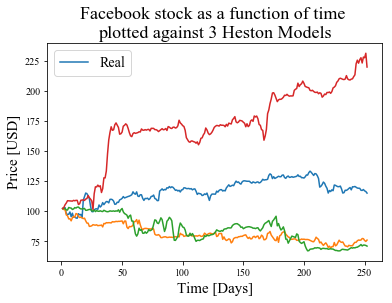

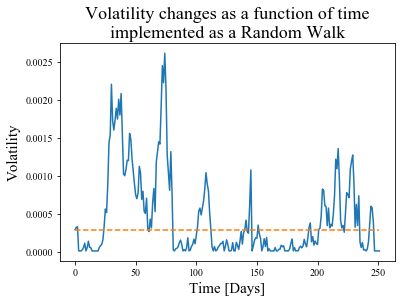

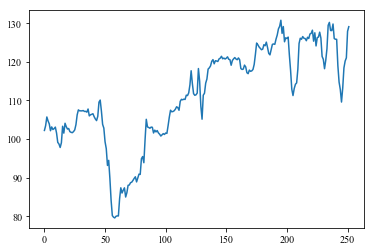

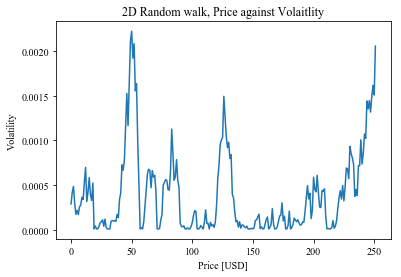

In [54]:
plt.title("Facebook stock as a function of time \nplotted against 3 Heston Models", fontsize=18)
days = list(range(1, len(heston_preds[0]) + 1))
    
# plot all stocks
for stock in [close_data, *(heston_preds[:3])]:
    plt.plot(days, stock)

# output
plt.xlabel("Time [Days]", fontsize=15)
plt.ylabel("Price [USD]", fontsize=15)
plt.legend(["Real"], fontsize=14)
plt.show()

plot_random_vol()
plot_2D_random_walk()

## Heston Model implied Volatiltiy

In [56]:
def guess_max_c(preds, K, T, r, sig):
    guesses_c = []
    
    for pred in preds:
        # Say the user uses the option in T time
        # Then the income he will get will be of the form:
        future_income = (pred[T] - K) * math.pow(math.e, -r * T) 

        # Therefore the most he should pay for an option is around this value
        guesses_c.append(max(0, future_income))

    return np.mean(guesses_c)


def black_shcoles_call(S, K, T, r, sigma):

    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    call = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))

    return call

def min_func(sigma, S, K, T, r, C):
    if sigma < 0:
        return np.inf
    bs_val = black_shcoles_call(S, K, T, r, sigma)
    return abs(bs_val - C)


def binary_search(start_sig, end_sig, S, K, r, T, C):
    curr_sig = (start_sig + end_sig) / 2
    print(curr_sig)
    curr_c = min_func(curr_sig, S, K, T ,r, C)
    if abs(curr_c - C) < 0.01:
        return curr_sig
    if curr_c > C:
        return binary_search(curr_sig, end_sig, S, K, r, T, C)
    else:
        return binary_search(start_sig, curr_sig, S, K, r, T, C)
        
    
def implied_sig(S, K, r, T, C):
    return newton(
        min_func,
        0.02,
        args = (
            S,
            K,
            T,
            r,
            C
        ),
        tol=0.000001,
        maxiter=100000
    )

## Black and Shcoles - No Smile

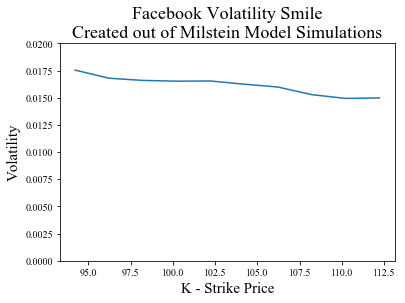

In [60]:
ms_preds, em_preds = simulate_prices_old(False, simulations=1000)

exp = 50
implied_vols = []

# find some relevant k's
k_samples = 10
k_list = [close_data[0] - 10 +  20 * (K / k_samples) for K in range(1, k_samples + 1)]
for K in k_list: 
    guessed_max_c = guess_max_c(ms_preds, K, exp, DEFAULT_R, (DEFAULT_SIG))
    #bs_max_c = black_shcoles_call(close_data[0], K, T, DEFAULT_R, DEFAULT_SIG)   
    #implied_vol = binary_search(0, 0.5, close_data[0], K, DEFAULT_R, T, bs_max_c)
    implied_vol = implied_sig(close_data[0], K, DEFAULT_R, exp, guessed_max_c) 
    implied_vols.append(implied_vol)
    
plt.title("Facebook Volatility Smile\nCreated out of Milstein Model Simulations", fontsize=18)
plt.plot(k_list, implied_vols)
plt.ylim([0, 0.02])
plt.xlabel("K - Strike Price", fontsize=15)
plt.ylabel("Volatility", fontsize=15)
plt.show()

## Heston Model - Volatility Smile

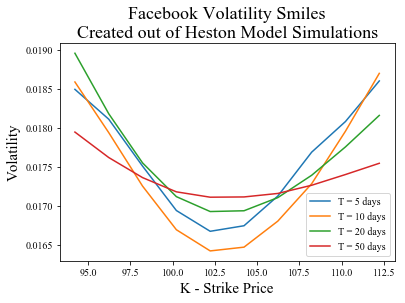

In [64]:
T=252

heston_preds = simulate_prices_heston(False, simulations=5000)
heston_avg_pred = np.mean(heston_preds, axis=0)

# find some relevant k's
plt.title("Facebook Volatility Smiles\nCreated out of Heston Model Simulations", fontsize=18)

for exp in [5, 10, 20, 50]:
    implied_vols = []

    k_samples = 10
    k_list = [close_data[0] - 10 +  20 * (K / k_samples) for K in range(1, k_samples + 1) ]
    for K in k_list: 
        guessed_max_c = guess_max_c(heston_preds, K, exp, DEFAULT_R, (DEFAULT_SIG))    
        implied_vol = implied_sig(close_data[0], K, DEFAULT_R, exp, guessed_max_c) 
        implied_vols.append(implied_vol)
    
    
    
    days = list(range(1, len(heston_preds[0]) + 1))

    # plot all stocks
    plt.plot(k_list, implied_vols)

# output
plt.legend(["T = 5 days", "T = 10 days", "T = 20 days", "T = 50 days"])
plt.xlabel("K - Strike Price", fontsize=15)
plt.ylabel("Volatility", fontsize=15)
plt.show()

## Newton Raphson Visualization

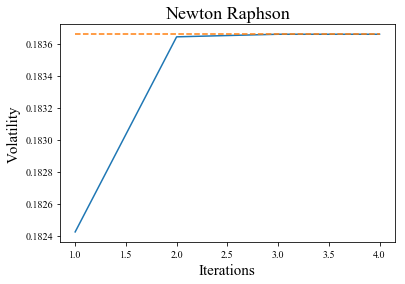

In [69]:
def implied_sig_slow(S, K, r, T, C):
    lst = []
    x =  list(range(1, 5))
    for iterations in x:
        lst.append(newton(
            min_func,
            0.02,
            args = (
                S,
                K,
                T,
                r,
                C
            ),
            
            tol=0.000001,
            maxiter=iterations,
            disp=False
        ))
                 
    plt.title("Newton Raphson", fontsize=18)
    plt.xlabel("Iterations", fontsize=15)
    plt.ylabel("Volatility", fontsize=15)
    plt.plot(x, lst)
    plt.plot(x, [lst[-1]] * len(x), linestyle="--")
    plt.show()

implied_sig_slow(102.220001221, 102.5, 0.000625570019147, 5, 16.646982665)
